# Teranet database
# OSEMN methodology Step 1: Scrub
# Step 1.1 Spatial join of Teranet points with GTHA Dissemination Area geometry
## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

## Load geometry of GTHA Dissemination Areas (DAs)

----- GeoDataFrame loaded
in 21.76 seconds
with 9,182 rows
and 4 columns
-- Column names:
 Index(['OBJECTID', 'DAUID', 'CSDNAME', 'geometry'], dtype='object')


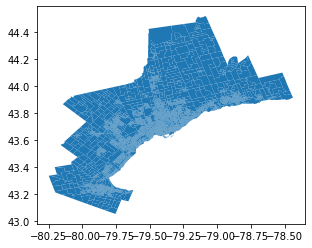

In [2]:
t = time()
api_url = 'https://opendata.arcgis.com/datasets/9d262f8a576842fbb2afbc8c51a64178_1.geojson'
da_gdf = gpd.read_file(api_url)

cols = ['OBJECTID', 'DAUID', 'CSDNAME', 'geometry']
da_gdf = da_gdf[cols]

elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(da_gdf.shape[0], da_gdf.shape[1]) + 
      "\n-- Column names:\n", da_gdf.columns)
      
da_gdf.plot();

## Load Teranet data

In [3]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['HHSaleHistory.csv']

In [4]:
t = time()
teranet_df = pd.read_csv(data_path + 'HHSaleHistory.csv',
                         na_values=" ")
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\nCRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

----- DataFrame loaded
in 15.47 seconds
with 9,039,241 rows
and 15 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 64.70 seconds
with 9,039,241 rows
and 16 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'geometry'],
      dtype='object')

CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!


## Perform spatial join of Teranet points with DA polygons
### Validate projections

In [5]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [6]:
da_gdf.crs

{'init': 'epsg:4326'}

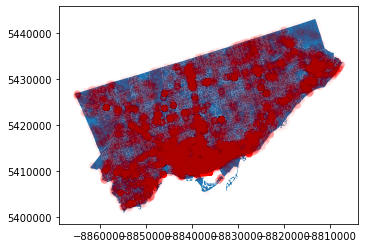

In [7]:
# plot DA polygon for Toronto
ax = da_gdf.query("CSDNAME == 'Toronto'").to_crs(epsg=3857).plot()
# plot Teranet records for Toronto
teranet_gdf.query("MUNICIPALITY == 'Toronto'").to_crs(epsg=3857).plot(ax=ax,
                                                                      color='red',
                                                                      alpha=0.01)

### Perform the spatial join

In [8]:
t = time()
teranet_da_gdf = gpd.sjoin(teranet_gdf.to_crs(da_gdf.crs), da_gdf, 
                           how='inner', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_da_gdf.shape[0], teranet_da_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_da_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 1206.94 seconds
with 9,039,241 rows
and 16 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'geometry'],
      dtype='object')


In [9]:
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_da_gdf.shape[0], teranet_da_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_da_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 1206.94 seconds
with 6,803,691 rows
and 20 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'geometry', 'index_right',
       'OBJECTID', 'DAUID', 'CSDNAME'],
      dtype='object')


### Save results to file